In [8]:
#load aiida environment and connect to database
from aiida import load_profile
from aiida.orm import computers
profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [321]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData, ArrayData
from aiida.orm import (Group, load_group, load_node, load_code, groups, Node,
                      WorkChainNode, QueryBuilder, CalcJobNode)
from aiida.engine import submit
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import (kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, combine_imps_wc,
                                 kkr_flex_wc)
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation, KkrCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username
from masci_tools.io.common_functions import get_Ry2eV
import tarfile
import matplotlib as mpl


In [10]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals
from builtins import object, str
from six.moves import range
from six.moves import input
from masci_tools.io.common_functions import open_general
from masci_tools.io.common_functions import search_string
import numpy as np
from masci_tools.io.common_functions import get_alat_from_bravais
from masci_tools.io.common_functions import vec_to_angles
from aiida.common.constants import elements as PeriodicTableElements
_atomic_numbers = {data['symbol']:num for num,
                data in PeriodicTableElements.items()}
load_stuc = load_node(234)
load_stuc

<StructureData: uuid: c1626804-5b71-450c-91c4-aa7197d85279 (pk: 234)>

In [11]:
node_16215 = load_node(16215)
node_16100 = load_node(16100)
# node_16215.outputs.
# node_16100.outputs.workflow_info.pk

In [ ]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

In [ ]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
#     # highlight the contibution of the impurity (iatom=0)
#     plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
#              noshow=True, nofig=True, color='C'+str(i),
#              lw=3, iatom=0, 
#             )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

No handles with labels found to put in legend.


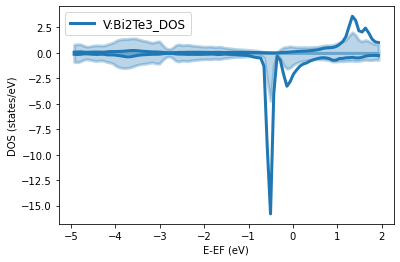

In [138]:
plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[3:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

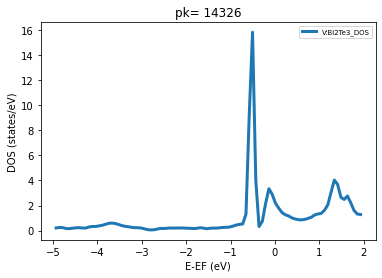

In [139]:
 plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0,all_atoms= False, sum_spins= True,)

In [46]:
qb1 = QueryBuilder()
node_list = qb1.append(WorkChainNode,
          filters={
#               'and':[
#                   {'attributes.process_label':'combine_imps_wc'},
#                   {'attributes.exit_status':{'in':[0]}}
                  
#               ],
              'id':{'>':60746},
              'attributes.process_label':'combine_imps_wc',
              
          }
         ).all()

In [47]:
nodes_list = [node[0] for node in node_list[:]]
# nodes_list.pop(19)
nodes_pk = [node.pk for node in nodes_list]
len(nodes_pk)

35

In [54]:
group = load_group(105)
group_nodes = list(group.nodes)
group_labels_end = [node.label.split(':')[-1] for node in group_nodes]
group_labels = [node.label for node in group_nodes]
group_pk = [node.pk for node in group_nodes]

for node in nodes_list:
    if node.pk not in group_pk:
#         print(node.pk)
#         print(node.label)
        if node.label.split(':')[-1]  in group_labels_end:
            if node.label not in group_labels:
                print (node.label)
                print(node.pk)
#                 group.add_nodes(node)
    

Y:Co:Bi2Te3_il_3_il_3
61086
Zr:Fe:Bi2Te3_il_3_il_3
61087
Zr:Co:Bi2Te3_il_3_il_3
61098
Mo:Fe:Bi2Te3_il_3_il_3
61140
Mo:Co:Bi2Te3_il_3_il_3
61141
Nb:Fe:Bi2Te3_il_3_il_3
61169
Nb:Co:Bi2Te3_il_3_il_3
61170
Tc:Fe:Bi2Te3_il_3_il_3
61192
Tc:Co:Bi2Te3_il_3_il_3
61193
Ru:Fe:Bi2Te3_il_3_il_3
61215
Ru:Co:Bi2Te3_il_3_il_3
61216
Rh:Fe:Bi2Te3_il_3_il_3
61238
Rh:Co:Bi2Te3_il_3_il_3
61260
Cd:Co:Bi2Te3_il_3_il_3
61264
Pd:Fe:Bi2Te3_il_3_il_3
61336
Pd:Co:Bi2Te3_il_3_il_3
61337


In [49]:
group_107 = load_group(108)
# group_107.add_nodes(nodes_list)
group_pk

[]

In [85]:
nodes_list[0], nodes_list[-1]

(<WorkChainNode: uuid: e3211b60-0cf7-4c99-9c43-25871255f272 (pk: 57971) (aiida_kkr.workflows._combine_imps.combine_imps_wc)>,
 <WorkChainNode: uuid: 0703d125-2db7-48b3-a613-e4cf9f3a0b94 (pk: 58236) (aiida_kkr.workflows._combine_imps.combine_imps_wc)>)

In [86]:
## duccess group
group_102 = load_group(104)
group_102_nodes = list(group_102.nodes)
group_102_nodes_pk = [i.pk for i in group_102_nodes]
group_102_nodes_label = [i.label for i in group_102_nodes]

## failed group
group_105 = load_group(106)
group_105_nodes = list(group_105.nodes)
group_105_nodes_pk = [i.pk for i in group_105_nodes]
group_105_nodes_label = [i.label for i in group_105_nodes]

len(group_102.nodes)

378

In [87]:
search_label = group_102_nodes[1].label.split(':')[-1]
node_num_with_label = 0
print('search_label:  ', search_label)
candidate_label = group_102_nodes[-1].label.split(':')[-1]
print('candidate : ', candidate_label)
N = 0
for node in nodes_list[:]:
    candidate_label = node.label.split(':')[-1]
#     print(f'search_label :  {search_label},  candidate_label : {candidate_label}')
    if candidate_label == search_label:
        N += 1
        node_num_with_label += 1
        if node.is_finished :
            if node.is_finished_ok :
#                 group_102_nodes_pk.remove(node.pk)
                if node.pk not in group_102_nodes_pk:
                    if node.label not in group_102_nodes_label:
                        print('not in group 102 : ', node.pk)
                        
                        group_102.add_nodes(node)
            else:
                if node.pk not in group_105_nodes_pk:
                    if node.label not in group_105_nodes_label:
                        print('failed node pk : ',  node.pk)
                        group_105.add_nodes(node)
        else:
            print('runing_node : ', node.pk)
            group_102.add_nodes(node)
                
print(N)

search_label:   Bi2Te3_il_3_il_4
candidate :  Bi2Te3_il_3_il_4
29


In [114]:
group_3_vs_3 = load_group(102)
node_3_3_list = list(group_3_vs_3.nodes)
node_1 = node_3_3_list[0]
node_1.outputs.last_calc_output_parameters.get_dict()['magnetism_group']['total_spin_moment'] #0.4991457961, 

0.732977

In [116]:
node_1.label.split(':')[0], node_1.label.split(':')[1] 

('Sc', 'Ti')

In [154]:
node_16195 = load_node(58236)
# node_16195.outputs.last_calc_output_parameters.get_dict()
node_16195.outputs.JijData.get_array('JijData')
print(node_16195.outputs.JijData.get_array('JijData')[0,:])
test =  (node_16195.outputs.JijInfo.get_dict()['text']).split('\n')

# list(test[2].split(''))
int(test[3].split()[0])

[ 0.00000000e+00  0.00000000e+00  5.82221121e-01  1.09233952e-23
  4.71157372e-24  1.68344619e-24  1.39475763e-24 -4.17367787e-24]


0

In [144]:
list_1 = [2,2,3,5]
dist_1 = np.sum(list_1)
list_1[0:3]

[2, 2, 3]

In [159]:
from aiida.common.constants import elements as elmt
sym_to_zimp = {elmt[zimp]['symbol']:zimp for zimp in elmt.keys()}

In [177]:
## To plot Dyaloshinky data
combine_imps_group = load_group(102)
combine_nodes_list = list(combine_imps_group.nodes)
plot_imp_row_list = []  # This is the list considered as the label for yticks
plot_imp_col_list = ['xx']  # This is the list considered as the label for xticks

for node in combine_nodes_list[:]:
    ## Here to arrange the imps for once, intending for x-axis, 
    ## plot_col_list, and y-axis, plot_row_list 
    imp1, imp2 = node.label.split(':')[0], node.label.split(':')[1]
    ## Here only one imp will be consider for once
    if imp1 not in plot_imp_row_list:
        plot_imp_row_list.append(imp1)
    if imp2 not in plot_imp_col_list:
        plot_imp_col_list.append(imp2)
    
    plot_zimp_row_list = [] 
    plot_zimp_col_list = []    
    
    for sym in plot_imp_row_list:
        if sym in sym_to_zimp.keys():
            plot_zimp_row_list.append(sym_to_zimp[sym])
        else:
            plot_zimp_row_list.append(0)
    plot_zimp_row_list.sort()       
    for sym in plot_imp_col_list:
        if sym in sym_to_zimp.keys():
            plot_zimp_col_list.append(sym_to_zimp[sym])
        else:
            plot_zimp_col_list.append(0)
    plot_zimp_col_list.sort()
    plot_imp_row_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_row_list]
    plot_imp_col_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_col_list]
    
            
plot_imp_col_list

['X',
 'Sc',
 'Ti',
 'V',
 'Cr',
 'Mn',
 'Fe',
 'Co',
 'Ni',
 'Cu',
 'Zn',
 'Y',
 'Zr',
 'Nb',
 'Mo',
 'Tc',
 'Ru',
 'Rh',
 'Pd',
 'Ag',
 'Cd']

In [37]:
group_102 = load_group(105)
group_102_nodes = group_102.nodes
sym_list = []
for node in group_102_nodes:
    node_label = node.label
    sym_list.append(node_label)

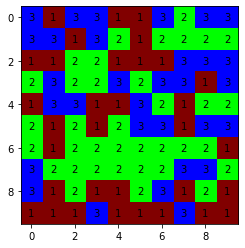

In [6]:
# import packages 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# generate data 
np.random.seed(42)
data = np.random.randint(low=1, high=4, size=(10,10)) # possible values are 1,2,3

# define color map 
color_map = {1: np.array([129, 0, 0]), # red
             2: np.array([0, 255, 0]), # green
             3: np.array([0, 0, 255])} # blue 

# make a 3d numpy array that has a color channel dimension   
data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 3), dtype=int)
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        data_3d[i][j] = color_map[data[i][j]]

# display the plot 
fig, ax = plt.subplots(1,1)
ax.imshow(data_3d)

# add numbers to the plot 
# thanks to tmdavison answer here https://stackoverflow.com/a/40890587/7871710
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        c = data[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

In [13]:
test_dict = {0:'zero', 1:'one'}

test_dict.

Sc:Fe:Bi2Te3_il_3_il_3   and pk :  60746
Fe:Co:Bi2Te3_il_3_il_3   and pk :  60873
Zn:Co:Bi2Te3_il_3_il_3   and pk :  60977
Ti:Co:Bi2Te3_il_3_il_3   and pk :  60775
V:Fe:Bi2Te3_il_3_il_3   and pk :  60802
V:Co:Bi2Te3_il_3_il_3   and pk :  60803
Cr:Fe:Bi2Te3_il_3_il_3   and pk :  60830
Mn:Co:Bi2Te3_il_3_il_3   and pk :  60858
Co:Fe:Bi2Te3_il_3_il_3   and pk :  60897
Ni:Fe:Bi2Te3_il_3_il_3   and pk :  60950
Zn:Fe:Bi2Te3_il_3_il_3   and pk :  60975
Y:Fe:Bi2Te3_il_3_il_3   and pk :  61005
Fe:Fe:Bi2Te3_il_3_il_3   and pk :  60872
Co:Ni:Bi2Te3_il_3_il_3   and pk :  60901
Sc:Co:Bi2Te3_il_3_il_3   and pk :  60747
Ti:Fe:Bi2Te3_il_3_il_3   and pk :  60774
Cr:Co:Bi2Te3_il_3_il_3   and pk :  60831
Co:Co:Bi2Te3_il_3_il_3   and pk :  60898
Co:Cu:Bi2Te3_il_3_il_3   and pk :  60930
Ni:Co:Bi2Te3_il_3_il_3   and pk :  60951


In [112]:
group = load_group(105)
group_nodes = list(group.nodes)
couple_list = []
uncoupled_list= []
i=0
for node1 in group_nodes[:]:
    for node2 in group_nodes[:]:
        i += 1
        imp1_node1, imp2_node1 = node1.label.split(':')[0], node1.label.split(':')[1]
        imp1_node2, imp2_node2 = node2.label.split(':')[0], node2.label.split(':')[1]
        if imp1_node1 == imp2_node2:
            if imp2_node1 == imp1_node2:
                print(f'Couple combination : {node1.label} & {node2.label}')
                couple_list.append(node1)
                couple_list.append(node2)
                
    if node1 not in couple_list:
        if node1 not in uncoupled_list:
            uncoupled_list.append(node1)
            print(f'Not Couple combination  available : {node1.label}, pk : {node1.pk}')

# uncoupled_list

Not Couple combination  available : Sc:Fe:Bi2Te3_il_3_il_3, pk : 60746
Couple combination : Fe:Co:Bi2Te3_il_3_il_3 & Co:Fe:Bi2Te3_il_3_il_3
Not Couple combination  available : Zn:Co:Bi2Te3_il_3_il_3, pk : 60977
Not Couple combination  available : Ti:Co:Bi2Te3_il_3_il_3, pk : 60775
Not Couple combination  available : V:Fe:Bi2Te3_il_3_il_3, pk : 60802
Not Couple combination  available : V:Co:Bi2Te3_il_3_il_3, pk : 60803
Not Couple combination  available : Cr:Fe:Bi2Te3_il_3_il_3, pk : 60830
Not Couple combination  available : Mn:Co:Bi2Te3_il_3_il_3, pk : 60858
Couple combination : Co:Fe:Bi2Te3_il_3_il_3 & Fe:Co:Bi2Te3_il_3_il_3
Not Couple combination  available : Ni:Fe:Bi2Te3_il_3_il_3, pk : 60950
Not Couple combination  available : Zn:Fe:Bi2Te3_il_3_il_3, pk : 60975
Not Couple combination  available : Y:Fe:Bi2Te3_il_3_il_3, pk : 61005
Couple combination : Fe:Fe:Bi2Te3_il_3_il_3 & Fe:Fe:Bi2Te3_il_3_il_3
Couple combination : Co:Ni:Bi2Te3_il_3_il_3 & Ni:Co:Bi2Te3_il_3_il_3
Not Couple combin

In [117]:
success_group = load_group(102)
failed_group = load_group(105)

succeed_group_labels = {node.label:node.pk for node in success_group.nodes}
failed_group_labels = {node.label:node.pk for node in failed_group.nodes}

uncoupled_list_failed_labels = [node.label for node in uncoupled_list]
uncoupled_list_success_labels = []

for label in uncoupled_list_failed_labels:
    imp1_sym = label.split(':')[0]
    imp2_sym = label.split(':')[1]
    host_sym = label.split(':')[2]
    new_label = imp2_sym + ':' + imp1_sym + ':' + host_sym
    uncoupled_list_success_labels.append(new_label)
#     print(f'new label:  {new_label},  Old_label:  {label}')

for label in uncoupled_list_success_labels:
    if label in succeed_group_labels.keys():
        print(f'SUCCEDED LABEL : {label}, SUCCEDED PK: {succeed_group_labels[label]}')
for label in uncoupled_list_failed_labels:
    if label in failed_group_labels.keys():
        print(f'FAILED LABEL : {label}, FAILED PK: {failed_group_labels[label]}')
        

SUCCEDED LABEL : Fe:Sc:Bi2Te3_il_3_il_3, SUCCEDED PK: 42932
SUCCEDED LABEL : Co:Zn:Bi2Te3_il_3_il_3, SUCCEDED PK: 44657
SUCCEDED LABEL : Co:Ti:Bi2Te3_il_3_il_3, SUCCEDED PK: 44631
SUCCEDED LABEL : Fe:V:Bi2Te3_il_3_il_3, SUCCEDED PK: 43127
SUCCEDED LABEL : Co:V:Bi2Te3_il_3_il_3, SUCCEDED PK: 44635
SUCCEDED LABEL : Fe:Cr:Bi2Te3_il_3_il_3, SUCCEDED PK: 43193
SUCCEDED LABEL : Co:Mn:Bi2Te3_il_3_il_3, SUCCEDED PK: 44646
SUCCEDED LABEL : Fe:Ni:Bi2Te3_il_3_il_3, SUCCEDED PK: 43440
SUCCEDED LABEL : Fe:Zn:Bi2Te3_il_3_il_3, SUCCEDED PK: 43571
SUCCEDED LABEL : Fe:Y:Bi2Te3_il_3_il_3, SUCCEDED PK: 43572
SUCCEDED LABEL : Co:Sc:Bi2Te3_il_3_il_3, SUCCEDED PK: 44629
SUCCEDED LABEL : Fe:Ti:Bi2Te3_il_3_il_3, SUCCEDED PK: 43069
SUCCEDED LABEL : Co:Cr:Bi2Te3_il_3_il_3, SUCCEDED PK: 44641
SUCCEDED LABEL : Cu:Co:Bi2Te3_il_3_il_3, SUCCEDED PK: 48997
SUCCEDED LABEL : Co:Y:Bi2Te3_il_3_il_3, SUCCEDED PK: 44658
SUCCEDED LABEL : Fe:Zr:Bi2Te3_il_3_il_3, SUCCEDED PK: 43573
SUCCEDED LABEL : Co:Zr:Bi2Te3_il_3_il_3, SUC

In [ ]:
success_group.

In [94]:
group_102_labels.index('Co:Y:Bi2Te3_il_3_il_3')
group_102.nodes[152]

<WorkChainNode: uuid: 6916481b-0354-4bdc-962f-90a2aeb03f28 (pk: 44658) (aiida_kkr.workflows._combine_imps.combine_imps_wc)>

In [120]:
node_61131 = load_node(61131)
node_61131.outputs.output_parameters.get_dict()


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 8)

print('viridis.colors', viridis.colors)
print('viridis(range(8))', viridis(range(8)))
print('viridis(np.linspace(0, 1, 8))', viridis(np.linspace(0, 1, 20)))

viridis.colors [[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
viridis(range(8)) [[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
viridis(np.linspace(0, 1, 8)) [[0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.212395 0.359683 0.55171  1.      ]

In [122]:
plt.cm.li

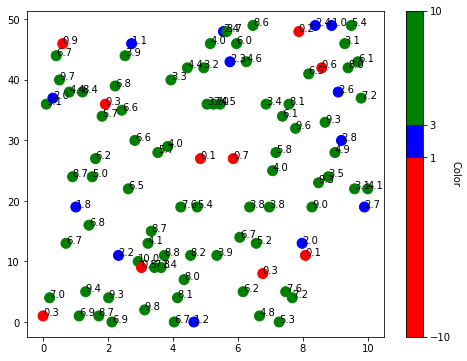

In [131]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

x = np.linspace(0, 10, 100)
y = np.random.randint(0, 50, size=100)
z = np.random.rand(100)*10

plt.figure(figsize=(8,6))



bounds = [-10,1,3,10]
colors = ["r", "b", "g"]

cmap = matplotlib.colors.ListedColormap(colors).se
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

rect = plt.scatter(x, y, s = 100, c=z, cmap=cmap, norm=norm)

cbar = plt.colorbar(rect, spacing="proportional")
cbar.set_label('Color', rotation=270, labelpad=10)

for i, txt in enumerate(z):
    plt.annotate(np.around(txt, 1), (x[i], y[i]))
plt.show()

In [215]:
node_54809 = load_node(54809)

gf_host_remote = node_54809.inputs.gf_host_remote.get_incoming(node_class=KkrCalculation).all()[0].node

# kkr_write = gf_host_remote.get_incoming(node_class=KkrCalculation).all()[0].node
# kkr_calc = kkr_write.outputs.output_parameters.get_dict()
gf_host_remote.outputs.output_parameters.get_dict()


import numpy as np

np.add([[1, 2, 3],[1, 2, 3],[1, 2, 3]], 0.5).tolist()

[[1.5, 2.5, 3.5], [1.5, 2.5, 3.5], [1.5, 2.5, 3.5]]

In [226]:
node_6916481b = load_node('6916481b-0354-4bdc-962f-90a2aeb03f28')
# node_6916481b.outputs.last_calc_output_parameters.get_dict()
# node_6916481b.outputs.output_parameters.get_dict()#['magnetism_group']

In [227]:
node_62155 = load_node(62151)
# node_62155.outputs.output_parameters.get_dict()#['magnetism_group']

In [297]:
node_62129 = load_node(62129)
input_param= node_62129.inputs.parameters.get_dict()
# input_param

In [252]:
node_16637 = load_node(16637)
print('node_16637.inputs.impurity_info.get_dict() : ', node_16637.inputs.impurity_info.get_dict())
node_16637.outputs.remote_data_gf

node_16637.inputs.impurity_info.get_dict() :  {'Rcut': 4.0, 'Zimp': [26.0], 'ilayer_center': 4}


<RemoteData: uuid: cdcbd086-129f-49fc-9132-791159854a37 (pk: 16648)>

In [258]:
test_node= load_node(16647)
test_node.inputs.parameters.get_dict()

{'FCM': 20.0,
 'INS': None,
 'EMAX': 1.2,
 'EMIN': -0.8,
 'GMAX': 65.0,
 'ICST': None,
 'IMIX': 5,
 'IRID': None,
 'LMAX': 3,
 'NAEZ': 10,
 'NMIN': None,
 'NPOL': 5,
 'NPT1': 5,
 'NPT2': 50,
 'NPT3': 3,
 'RMAX': 7.0,
 'EFSET': None,
 'FILES': None,
 'IEMXD': None,
 'IPAND': None,
 'KVREL': None,
 'NATYP': 10,
 'NCHEB': 12,
 'NSPIN': 2,
 'R_LOG': 0.8,
 'TEMPR': 800.0,
 '<SITE>': None,
 'BRYMIX': 0.04,
 'HFIELD': 0.0,
 'ITDBRY': 30,
 'JIJRAD': None,
 'KEXCOR': None,
 'KSHAPE': None,
 'N1SEMI': None,
 'N2SEMI': None,
 'N3SEMI': None,
 'NSHELD': None,
 'NSTEPS': 200,
 'QBOUND': 1e-07,
 'RUNOPT': ['LLOYD', 'NEWSOSOL', '...', '...', 'KKRFLEX'],
 'STRMIX': 0.01,
 'TKSEMI': None,
 'VCONST': None,
 '<LLOYD>': None,
 '<SHAPE>': None,
 '<ZATOM>': [52.0, 52.0, 52.0, 83.0, 83.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'BRAVAIS': [[-0.5, -0.2886751345, 2.3185997682],
  [0.5, -0.2886751345, 2.3185997682],
  [0.0, 0.577350269, 2.3185997682]],
 'CPAINFO': None,
 'EMUSEMI': None,
 'IVSHIFT': None,
 'LINIPOL': False,

In [268]:
node_24887= load_node(24898)
print('combine_imps_kkr :', node_24887.inputs.parameters.get_dict()['BZDIVIDE'])
node_2488= load_node(24887)
node_2488.inputs.host_gf__params_kkr_overwrite.get_dict()

combine_imps_kkr : [40, 40, 40]


{'NSHELD': 2500}

In [285]:
node_91_list= load_group(91).nodes
label_91_list= [node.label for node in node_91_list]
label_91_list

['Sc:Bi2Te3',
 'Mn:Bi2Te3',
 'Cr:Bi2Te3',
 'V:Bi2Te3',
 'Ti:Bi2Te3',
 'Ni:Bi2Te3',
 'Fe:Bi2Te3',
 'Y:Bi2Te3',
 'Zn:Bi2Te3',
 'Zr:Bi2Te3',
 'Cu:Bi2Te3',
 'Nb:Bi2Te3',
 'Mo:Bi2Te3',
 'Tc:Bi2Te3',
 'Rh:Bi2Te3',
 'Cd:Bi2Te3',
 'Pd:Bi2Te3',
 'Ru:Bi2Te3',
 'Ag:Bi2Te3',
 'Co:Bi2Te3']

In [279]:
node_23b1 = load_node(62177)
# node_23b1.inputs.parameters.get_dict()
node_62258 = load_node(62258)
node_62258.outputs.remote_folder.get_remote_path()

'/local/th1/iff003/mozumder/aiida_run/73/e4/e699-1455-449e-9e32-d6438f8ee0ae'

In [281]:
node_62167 = load_node(62167)

node_62167.label

'Co:Bi2Te3'

In [296]:
group_91 = load_group(106)
# node_24830 = load_node(24841)
# node_24830.inputs.parameters.get_dict()
list(group_91.nodes)

# group_91.clear()

[]

In [298]:
matplotlib.get_configdir()

'/home/mozumder/.config/matplotlib'

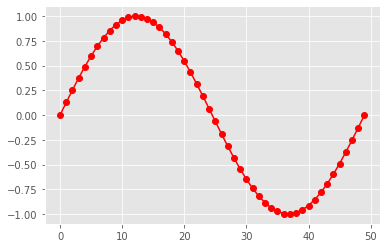

In [303]:
with plt.style.context('ggplot'):
    plt.plot(np.sin(np.linspace(0, 2 * np.pi)), 'r-o')
plt.show()

In [307]:
node_55717 = load_node(55717)
print(node_55717.label)

# node_55717.outputs.last_calc_output_parameters.get_dict()

Pd:Ru:Bi2Te3_il_3_il_3


TypeError: If only one positional argument given, it must  be a Cycler instance.

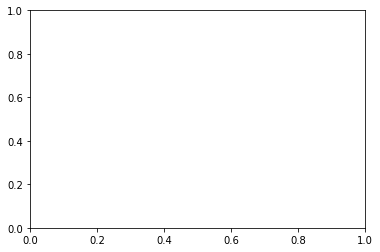

In [316]:
import matplotlib.pyplot as plt
import numpy as np

NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
cycle= plt.cycler([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax.set_prop_cycle(cycle)
for i in range(NUM_COLORS):
    ax.plot(np.arange(10)*(i+1))

fig.savefig('moreColors.png')
plt.show()

In [314]:
plt.cycler

<function cycler.cycler(*args, **kwargs)>

In [313]:
cm.c

In [317]:
np.random.random((5, 6))

array([[0.12188609, 0.18114935, 0.68111785, 0.18143835, 0.52516338,
        0.70904626],
       [0.10687692, 0.56731222, 0.25656278, 0.96292688, 0.48354565,
        0.80599255],
       [0.55022654, 0.04341253, 0.63315138, 0.95140334, 0.60161182,
        0.81918886],
       [0.88420646, 0.22807977, 0.21204484, 0.61098099, 0.41102847,
        0.8398613 ],
       [0.90002312, 0.35342138, 0.23687056, 0.78052552, 0.27480604,
        0.82261432]])

In [318]:
>>> import matplotlib
>>> matplotlib.matplotlib_fname()

'/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [324]:
# mpl.rcParams.keys()

In [328]:
node_55717 = load_node(55717)
print(node_55717.label)

out_dict= node_55717.outputs.last_calc_output_parameters.get_dict()

print(out_dict['magnetism_group']['spin_moment_per_atom'][0][2])
out_dict

Pd:Ru:Bi2Te3_il_3_il_3
-0.0054700908682372


{'nspin': 2,
 'energy': -2108300.9639281,
 'energy_unit': 'eV',
 'fermi_energy': 0.4991457961,
 'timings_unit': 'seconds',
 'use_newsosol': True,
 'parser_errors': [],
 'timings_group': {'energyloop': 213.59601495205,
  'gref->gmat': 0.4483846166195,
  'Iteration number': 215.39634743715,
  'gonsite->density': 50.102592321543,
  'Total running time': 8410.7265625,
  'time until scf starts': 10.244799613953},
 'parser_version': '0.4.2',
 'warnings_group': {'warnings_list': [], 'number_of_warnings': 0},
 'code_info_group': {'code_version': 'v3.1-1679-g1fae947',
  'compile_options': 'intel',
  'calculation_serial_number': '20210402051519'},
 'magnetism_group': {'spin_moment_unit': 'mu_Bohr',
  'total_spin_moment': 0.181881,
  'orbital_moment_unit': 'mu_Bohr',
  'spin_moment_per_atom': [[-0.00066449932690673,
    0.00027398506030878,
    -0.0054700908682372],
   [0.00012735308204678, -1.2427106928738e-05, 0.00016463993148452],
   [-8.7428477063955e-05, 0.0001086007740606, 0.000801493809291